In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from pymongo import MongoClient
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from talib import abstract

from functools import partial

In [2]:
#Download Data from yahoo
stock='TCS'
startdate='2007-01-01'
enddate='2022-01-01'
exchange=['.NS','.BO']
dfo = yf.download(stock+exchange[0],start=startdate)

[*********************100%***********************]  1 of 1 completed


In [3]:
df=dfo.copy()
df['pct_change']=(df['Adj Close'].pct_change())*100
df.dropna(inplace=True)

In [4]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2007-01-03   313.250000   322.000000   309.787506   320.037506   242.514114   
2007-01-04   321.250000   321.250000   312.524994   314.762512   238.516953   
2007-01-05   316.250000   317.149994   313.274994   315.750000   239.265152   
2007-01-08   314.750000   314.750000   303.750000   310.950012   235.627792   
2007-01-09   311.975006   315.462494   306.312500   314.100006   238.014923   
...                 ...          ...          ...          ...          ...   
2022-01-27  3731.000000  3733.399902  3625.100098  3649.250000  3649.250000   
2022-01-28  3646.000000  3729.800049  3646.000000  3690.050049  3690.050049   
2022-01-31  3749.000000  3758.000000  3721.399902  3736.250000  3736.250000   
2022-02-01  3770.000000  3808.000000  3736.399902  3800.649902  3800.649902   
2022-02-02  3827.899902  3864.000000  3800.649902  3856.199951  3856.199951   

             Volume  pct_change  
Date                             
2007-01-03  4384972    2.535067  
2007-01-04  3970700   -1.648218  
2007-01-05  2718740    0.313688  
2007-01-08  4951892   -1.520221  
2007-01-09  4020568    1.013094  
...             ...         ...  
2022-01-27  5718297   -3.200348  
2022-01-28  3143862    1.118039  
2022-01-31  2739393    1.252014  
2022-02-01  2105169    1.723651  
2022-02-02  1983657    1.461593  

[3719 rows x 7 columns]

In [5]:
##################### Here you can play with Windows and alpha ##########
def rwema(windows,df,field):
    
    for window in windows:
        alpha=1/window
        weights=list(reversed([(1-alpha)**n for n in range(window)]))
        ewma = partial(np.average, weights=weights)
        df['RWEMA_'+str(window)] = df[field].rolling(window).apply(ewma)
        
        df.dropna(inplace=True)
        ##########TO check how much  moving up or down from given point 
        count = 0
        cum_change=0
        base=[]
        for index, row in df.iterrows():
            if row['RWEMA_'+str(window)] <  row[field] :
                base.append(row[field])
                count += 1
                cum_change=((row[field]-base[0])/base[0])*100
                # cum_change=cum_change+row['pct_change']
            else:
                count = 0
                cum_change=0
                base.clear()
            df.loc[index, 'cum_above_0'] = count
            df.loc[index, 'cum_above_pct_change'] = cum_change

        count = 0
        cum_change=0
        base=[]
        for index, row in df.iterrows():
            if row['RWEMA_'+str(window)] >  row[field]:
                base.append(row[field])
                count -= 1
                cum_change=((row[field]-base[0])/base[0])*100
                # cum_change=cum_change+row['pct_change']
            else:
                count = 0
                cum_change=0
                base.clear()
            df.loc[index, 'cum_below_0'] = count
            df.loc[index, 'cum_below_pct_change'] = cum_change

        df['RWEMA_'+str(window)+'_movement']=df['cum_above_0']+df['cum_below_0']
        df['RWEMA_'+str(window)+'_price%movement']=df['cum_above_pct_change']+df['cum_below_pct_change']
        df.drop('cum_above_0',axis=1,inplace=True)
        df.drop('cum_below_0',axis=1,inplace=True)
        df.drop('cum_above_pct_change',axis=1,inplace=True)
        df.drop('cum_below_pct_change',axis=1,inplace=True)
    return df

# Stage - 1
## Basic Calculation
1. Calculate Moving Average
2. Calculate how many consicutive days price was trading above or below MA
3. Calculate Crossup and Cross Below Points.

## Output
1. How many times Price crossed above and below of MA
2. Price Skew w.r.t MA --> Postive means ,Price mostly traded above MA, -Ve means price traded below MA mostly .Large the % output ,Large the Skew towards that direction

In [6]:
window=[252]     #10 for week , 21 days a week -->53 days
field='Adj Close'
df=rwema(window,df,field)

In [7]:
#####RWEMA_<Days>_movement here is calculating number of days price stayed up or down of Moving average when crossed up or down .
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2008-01-07   250.000000   252.199997   243.125000   243.899994   186.840515   
2008-01-08   245.000000   248.000000   242.324997   246.962494   189.186508   
2008-01-09   248.699997   251.500000   247.475006   249.074997   190.804764   
2008-01-10   249.500000   252.375000   240.500000   245.412506   187.999115   
2008-01-11   228.837494   251.000000   228.837494   247.437500   189.550415   
...                 ...          ...          ...          ...          ...   
2022-01-27  3731.000000  3733.399902  3625.100098  3649.250000  3649.250000   
2022-01-28  3646.000000  3729.800049  3646.000000  3690.050049  3690.050049   
2022-01-31  3749.000000  3758.000000  3721.399902  3736.250000  3736.250000   
2022-02-01  3770.000000  3808.000000  3736.399902  3800.649902  3800.649902   
2022-02-02  3827.899902  3864.000000  3800.649902  3856.199951  3856.199951   

             Volume  pct_change    RWEMA_252  RWEMA_252_movement  \
Date                                                               
2008-01-07  3647344   -2.944662   213.777026                -1.0   
2008-01-08  3207732    1.255613   213.556675                -2.0   
2008-01-09  2450128    0.855376   213.356548                -3.0   
2008-01-10  3342376   -1.470429   213.137899                -4.0   
2008-01-11  2149188    0.825163   212.938220                -5.0   
...             ...         ...          ...                 ...   
2022-01-27  5718297   -3.200348  3453.806471               398.0   
2022-01-28  3143862    1.118039  3455.782568               399.0   
2022-01-31  2739393    1.252014  3457.973897               400.0   
2022-02-01  2105169    1.723651  3460.587221               401.0   
2022-02-02  1983657    1.461593  3463.607396               402.0   

            RWEMA_252_price%movement  
Date                                  
2008-01-07                  0.000000  
2008-01-08                  1.255613  
2008-01-09                  2.121729  
2008-01-10                  0.620101  
2008-01-11                  1.450381  
...                              ...  
2022-01-27                 75.554045  
2022-01-28                 77.516809  
2022-01-31                 79.739344  
2022-02-01                 82.837423  
2022-02-02                 85.509763  

[3468 rows x 10 columns]

In [8]:
##################To mark all rows when its above (1) or below (-1)
df['check']=np.where((df['RWEMA_252_movement']>0),1,-1)

#####When Crossing above its 1 and when crossing below its -1 otherwise zero
conditions=[(df['RWEMA_252_movement']>0)&(df['RWEMA_252_movement'].shift(1)<0),(df['RWEMA_252_movement']<0)&(df['RWEMA_252_movement'].shift(1)>0)]
values=[1,-1]
df['crossover']=np.select(conditions,values)

In [9]:

df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2008-01-07   250.000000   252.199997   243.125000   243.899994   186.840515   
2008-01-08   245.000000   248.000000   242.324997   246.962494   189.186508   
2008-01-09   248.699997   251.500000   247.475006   249.074997   190.804764   
2008-01-10   249.500000   252.375000   240.500000   245.412506   187.999115   
2008-01-11   228.837494   251.000000   228.837494   247.437500   189.550415   
...                 ...          ...          ...          ...          ...   
2022-01-27  3731.000000  3733.399902  3625.100098  3649.250000  3649.250000   
2022-01-28  3646.000000  3729.800049  3646.000000  3690.050049  3690.050049   
2022-01-31  3749.000000  3758.000000  3721.399902  3736.250000  3736.250000   
2022-02-01  3770.000000  3808.000000  3736.399902  3800.649902  3800.649902   
2022-02-02  3827.899902  3864.000000  3800.649902  3856.199951  3856.199951   

             Volume  pct_change    RWEMA_252  RWEMA_252_movement  \
Date                                                               
2008-01-07  3647344   -2.944662   213.777026                -1.0   
2008-01-08  3207732    1.255613   213.556675                -2.0   
2008-01-09  2450128    0.855376   213.356548                -3.0   
2008-01-10  3342376   -1.470429   213.137899                -4.0   
2008-01-11  2149188    0.825163   212.938220                -5.0   
...             ...         ...          ...                 ...   
2022-01-27  5718297   -3.200348  3453.806471               398.0   
2022-01-28  3143862    1.118039  3455.782568               399.0   
2022-01-31  2739393    1.252014  3457.973897               400.0   
2022-02-01  2105169    1.723651  3460.587221               401.0   
2022-02-02  1983657    1.461593  3463.607396               402.0   

            RWEMA_252_price%movement  check  crossover  
Date                                                    
2008-01-07                  0.000000     -1          0  
2008-01-08                  1.255613     -1          0  
2008-01-09                  2.121729     -1          0  
2008-01-10                  0.620101     -1          0  
2008-01-11                  1.450381     -1          0  
...                              ...    ...        ...  
2022-01-27                 75.554045      1          0  
2022-01-28                 77.516809      1          0  
2022-01-31                 79.739344      1          0  
2022-02-01                 82.837423      1          0  
2022-02-02                 85.509763      1          0  

[3468 rows x 12 columns]

In [10]:
##To check how many times price crossed up and down of MA
up=df.groupby('crossover').Close.count()[1]
down=df.groupby('crossover').Close.count()[-1]
print(f"Price crossed up {up} times")
print(f"Price crossed below {down} times")

Price crossed up 51 times
Price crossed below 50 times


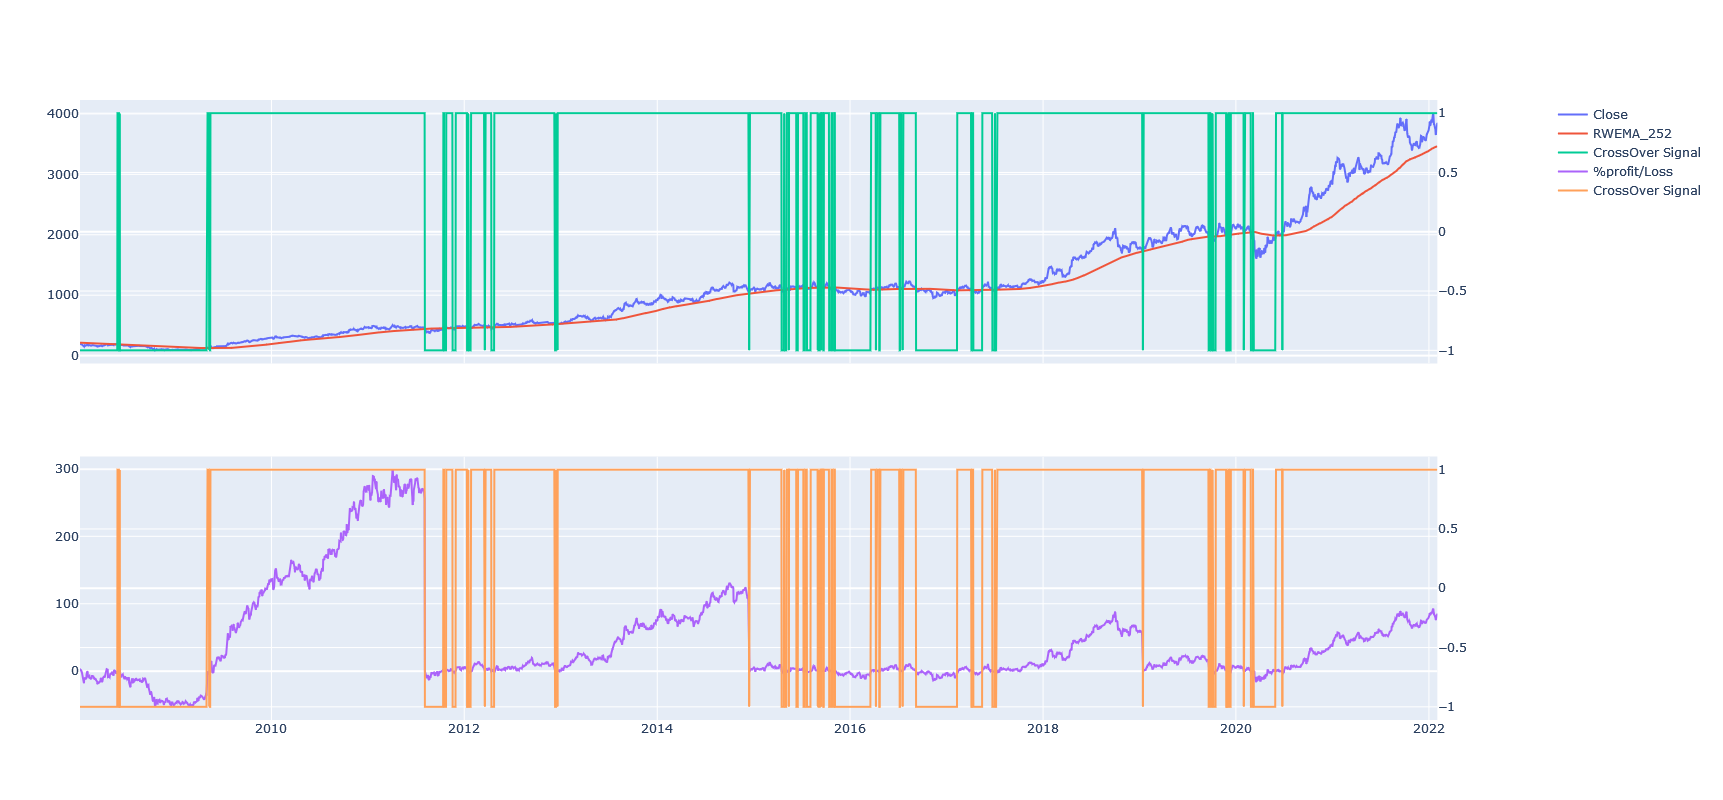

In [11]:
##################Ploting close,ma and check(to see when close crossing above or below of ma)
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,specs=[[{"secondary_y": True}],[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df.index,y=df['Adj Close'],mode='lines',name='Close'),secondary_y=False,row=1, col=1)
fig.add_trace(go.Scatter(x=df.index,y=df['RWEMA_252'],mode='lines',name='RWEMA_252'),secondary_y=False,row=1, col=1)
fig.add_trace(go.Scatter(x=df.index,y=df['check'],mode='lines',name='CrossOver Signal'),secondary_y=True,row=1, col=1)

fig.add_trace(go.Scatter(x=df.index,y=df['RWEMA_252_price%movement'],mode='lines',name='%profit/Loss'),secondary_y=False,row=2, col=1)
fig.add_trace(go.Scatter(x=df.index,y=df['check'],mode='lines',name='CrossOver Signal'),secondary_y=True,row=2, col=1)

fig.update_traces(dict(marker_line_width=0))
# fig = px.line(df[['Close','RWEMA_252','RWEMA_252_movement']],title="")
                
# fig.update_traces(marker_color='green')
fig.update_layout(autosize=False,width=1400,height=800,paper_bgcolor="white",)
fig.show()

In [12]:
skew_data=df.groupby(df['check']).RWEMA_252_movement.count()

In [13]:
skew_data

check
-1     767
 1    2701
Name: RWEMA_252_movement, dtype: int64

In [14]:
skew_data=skew_data.to_frame()

In [15]:
## maximum total -ve Days
neg=skew_data.loc[skew_data.index<0].max()[0]
## maximum total +ve Days
pos=skew_data.loc[skew_data.index>0].max()[0]

## % MA Skew
skew=((pos-neg)/neg)*100
print(f"This Stock haing postive MA Skew of {round(skew,2)}% for MV 250 ")

This Stock haing postive MA Skew of 252.15% for MV 250 


### #####################################End of Stage-1#########################################################

# Stage - 2

In [16]:
########### Here We are Calculating How Many Times Price Touched Specfic number of Days. 
data=df.groupby(df['RWEMA_252_movement']).Close.count()

In [17]:
# Just to validate the count
# df.loc[(df['RWEMA_252_movement']==-2) & (df['RWEMA_252_movement'].shift(1)==-1)].count()

In [18]:
df2=data.to_frame()
df2.reset_index(inplace=True)
df2.rename(columns={'RWEMA_252_movement':'#Days','Close':'#Times_Approched'},inplace=True)
df2.set_index('#Days',inplace=True)

In [19]:
df2.head()

#Times_Approched
#Days                   
-216.0                 1
-215.0                 1
-214.0                 1
-213.0                 1
-212.0                 1

In [20]:
####### Genric Information 
print(f"maximum number of days traded downside is {abs(df2.head(1).index[0])}")
print(f"maximum number of days traded upside is {abs(df2.tail(1).index[0])}")
df2.loc[df2.index>0].head(),df2.loc[df2.index<0].tail()

maximum number of days traded downside is 216.0
maximum number of days traded upside is 557.0


(       #Times_Approched
 #Days                  
 1.0                  51
 2.0                  40
 3.0                  34
 4.0                  30
 5.0                  29,
        #Times_Approched
 #Days                  
 -5.0                 17
 -4.0                 24
 -3.0                 28
 -2.0                 37
 -1.0                 51)

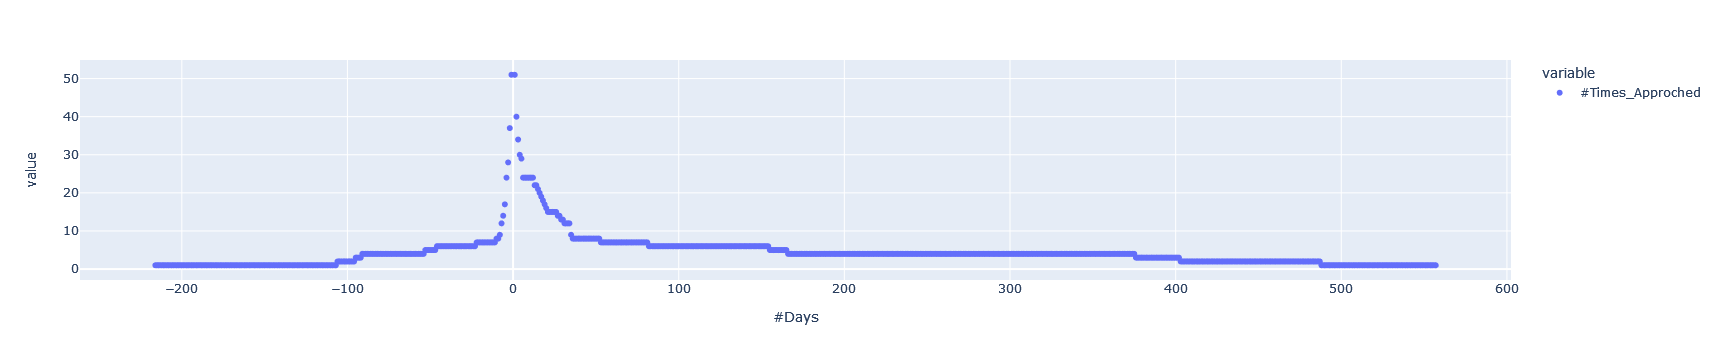

In [21]:
fig=px.scatter(df2)
fig.show()

In [22]:
################ Segrigated Main Stage 2 DF(df2) to two df's .One for when price crossed up and traded above, and other one when price crossed below and traded below  
df2_up=df2.loc[df2.index>0]
df2_down=df2.loc[df2.index<0]
df2_down=df2_down.iloc[::-1]

In [23]:
df2_up.head(),df2_down.head()

(       #Times_Approched
 #Days                  
 1.0                  51
 2.0                  40
 3.0                  34
 4.0                  30
 5.0                  29,
        #Times_Approched
 #Days                  
 -1.0                 51
 -2.0                 37
 -3.0                 28
 -4.0                 24
 -5.0                 17)

In [24]:
########This Section will merge the up and down df's into one and will add coluns acc to up days and down days .
df2_up_temp=df2_up.copy()
df2_up_temp.reset_index(inplace=True)
df2_up_temp.rename(columns={'#Times_Approched':'#Times_Approched_UP'},inplace=True)

df2_down_temp=df2_down.copy()
df2_down_temp.reset_index(inplace=True)
df2_down_temp['#Days']=df2_down_temp['#Days'].abs()
df2_down_temp.rename(columns={'#Times_Approched':'#Times_Approched_DOWN'},inplace=True)

df2_tmp=df2_up_temp.merge(df2_down_temp,on='#Days',how='outer')
df2_tmp.replace(to_replace=np.nan,value=0,inplace=True)

df2_tmp=df2_tmp.astype(int)

df2_tmp.set_index('#Days',inplace=True)

In [25]:
df2_tmp

#Times_Approched_UP  #Times_Approched_DOWN
#Days                                            
1                       51                     51
2                       40                     37
3                       34                     28
4                       30                     24
5                       29                     17
...                    ...                    ...
553                      1                      0
554                      1                      0
555                      1                      0
556                      1                      0
557                      1                      0

[557 rows x 2 columns]

## 

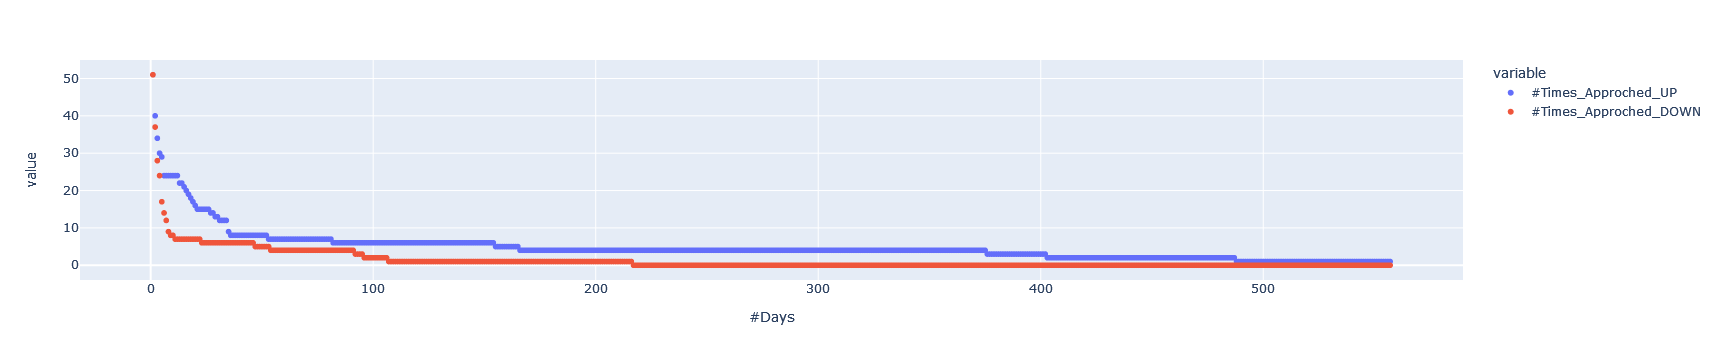

In [26]:
### Shows comparison of how many days reached  when in up move  vs down move from MA 
fig=px.scatter(df2_tmp)
fig.show()

In [27]:
### Will calculate % Chances to reach up to specfic number of days during up move or down move 
df2_tmp['%Chance_toApproched_UP']=(df2_tmp['#Times_Approched_UP']/df2_tmp['#Times_Approched_UP'].max())*100
df2_tmp['%Chance_toApproched_DOWN']=(df2_tmp['#Times_Approched_DOWN']/df2_tmp['#Times_Approched_DOWN'].max())*100


In [28]:
df2_tmp

#Times_Approched_UP  #Times_Approched_DOWN  %Chance_toApproched_UP  \
#Days                                                                       
1                       51                     51              100.000000   
2                       40                     37               78.431373   
3                       34                     28               66.666667   
4                       30                     24               58.823529   
5                       29                     17               56.862745   
...                    ...                    ...                     ...   
553                      1                      0                1.960784   
554                      1                      0                1.960784   
555                      1                      0                1.960784   
556                      1                      0                1.960784   
557                      1                      0                1.960784   

       %Chance_toApproched_DOWN  
#Days                            
1                    100.000000  
2                     72.549020  
3                     54.901961  
4                     47.058824  
5                     33.333333  
...                         ...  
553                    0.000000  
554                    0.000000  
555                    0.000000  
556                    0.000000  
557                    0.000000  

[557 rows x 4 columns]

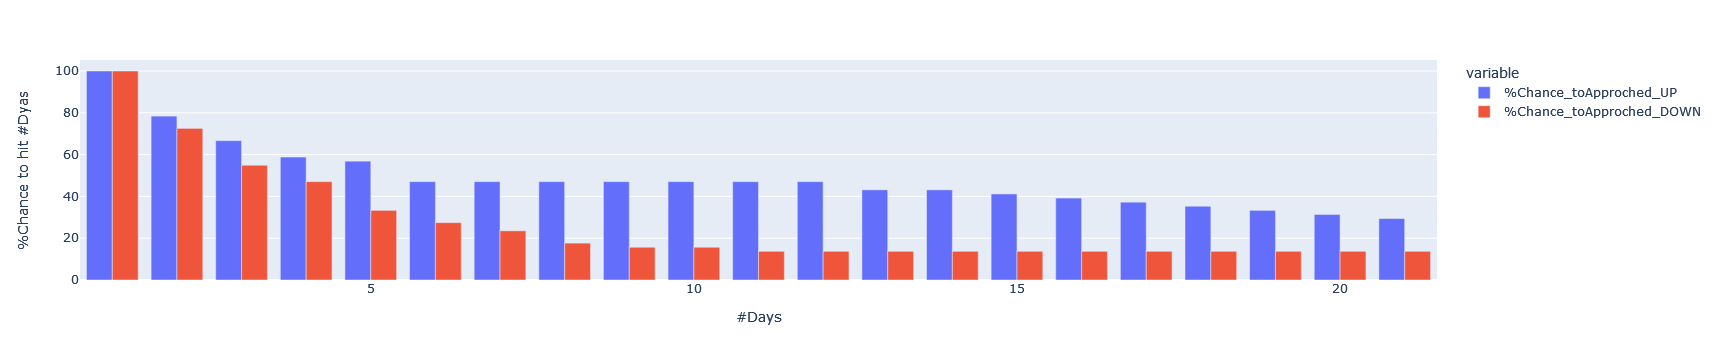

In [29]:

fig=px.bar(df2_tmp.loc[df2_tmp.index<22][['%Chance_toApproched_UP','%Chance_toApproched_DOWN']],barmode='group',labels={'value':'%Chance to hit #Dyas'})
fig.show()

# #################################END of Stage 2################################

# Stage 3
## Find % gain w.r.t #Days when crossing Above or Down 

In [30]:
data1=df.groupby(df['RWEMA_252_movement'])['RWEMA_252_price%movement'].mean()

In [31]:
df3=data1.to_frame()
df3.reset_index(inplace=True)
df3.rename(columns={'RWEMA_252_movement':'#Days','RWEMA_252_price%movement':'%Price Move'},inplace=True)
df3.set_index('#Days',inplace=True)

In [32]:
####### Genric Information 
print(f"maximum number of days traded downside is {abs(df3.head(1).index[0])}")
print(f"maximum number of days traded upside is {abs(df3.tail(1).index[0])}")
df3.loc[df3.index>0].head(),df3.loc[df3.index<0].tail()

maximum number of days traded downside is 216.0
maximum number of days traded upside is 557.0


(       %Price Move
 #Days             
 1.0       0.000000
 2.0       0.785998
 3.0       1.235253
 4.0       1.489394
 5.0       1.692019,
        %Price Move
 #Days             
 -5.0     -2.154329
 -4.0     -1.937376
 -3.0     -1.736596
 -2.0     -1.205286
 -1.0      0.000000)

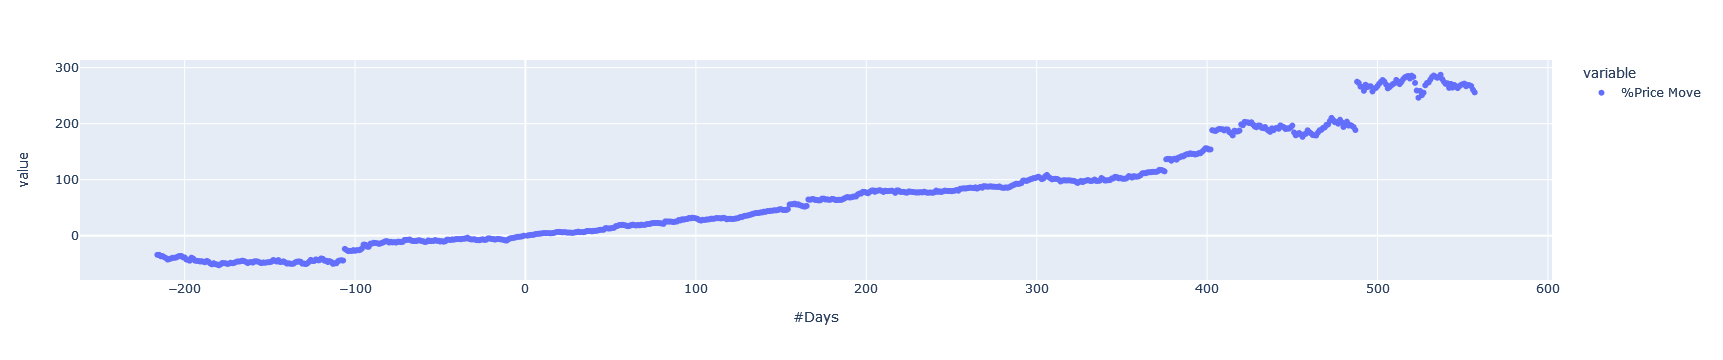

In [33]:
fig=px.scatter(df3)
fig.show()

In [34]:
################ Segrigated Main Stage 3 DF(df3) to two df's .One for when price crossed up and traded above, and other one when price crossed below and traded below  
df3_up=df3.loc[df3.index>0]
df3_down=df3.loc[df3.index<0]
df3_down=df3_down.iloc[::-1]

In [35]:
df3_up

%Price Move
#Days             
1.0       0.000000
2.0       0.785998
3.0       1.235253
4.0       1.489394
5.0       1.692019
...            ...
553.0   269.178018
554.0   268.609876
555.0   267.116213
556.0   260.524889
557.0   255.816848

[557 rows x 1 columns]

In [36]:
########This Section will merge the up and down df's into one and will add coluns acc to up days and down days .
df3_up_temp=df3_up.copy()
df3_up_temp.reset_index(inplace=True)
df3_up_temp.rename(columns={'%Price Move':'%Price Move UP'},inplace=True)

df3_down_temp=df3_down.copy()
df3_down_temp.reset_index(inplace=True)
df3_down_temp['#Days']=df3_down_temp['#Days'].abs()
df3_down_temp.rename(columns={'%Price Move':'%Price Move DOWN'},inplace=True)

df3_tmp=df3_up_temp.merge(df3_down_temp,on='#Days',how='outer')
df3_tmp.replace(to_replace=np.nan,value=0,inplace=True)

# df2_tmp=df2_tmp.astype(int)

df3_tmp.set_index('#Days',inplace=True)

In [37]:
df3_tmp

%Price Move UP  %Price Move DOWN
#Days                                  
1.0          0.000000          0.000000
2.0          0.785998         -1.205286
3.0          1.235253         -1.736596
4.0          1.489394         -1.937376
5.0          1.692019         -2.154329
...               ...               ...
553.0      269.178018          0.000000
554.0      268.609876          0.000000
555.0      267.116213          0.000000
556.0      260.524889          0.000000
557.0      255.816848          0.000000

[557 rows x 2 columns]

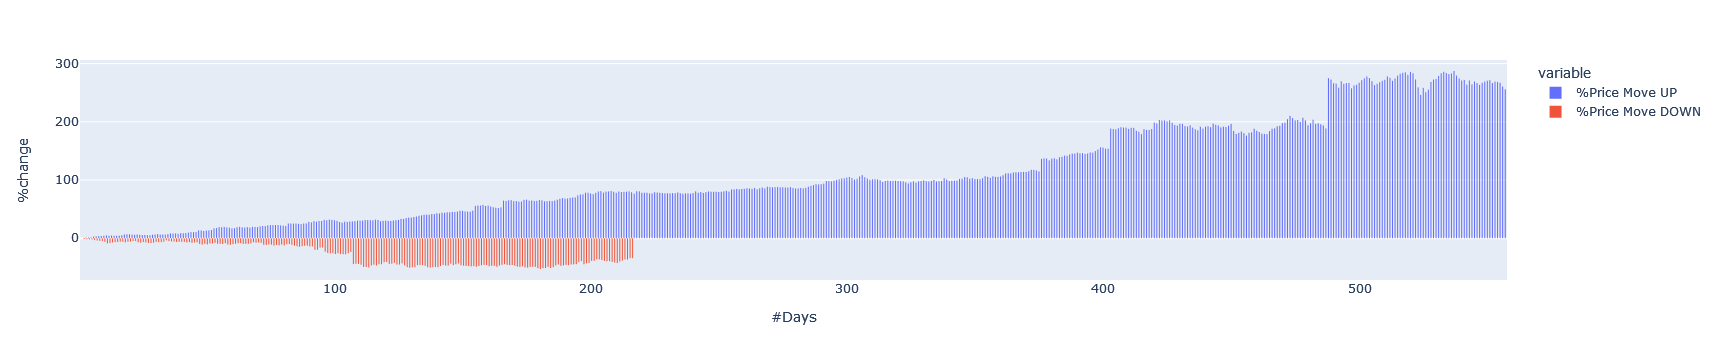

In [38]:
### Shows comparison of how many days reached  when in up move  vs down move from MA 
fig=px.bar(df3_tmp.loc[df3_tmp.index<590][['%Price Move UP','%Price Move DOWN']],barmode='group',labels={'value':'%change '})
fig.update_traces(dict(marker_line_width=0))
fig.show()

In [39]:
np.where(df['RWEMA_252_movement']==df['RWEMA_252_movement'].max())
df[883-556:884]


Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-05-15  156.000000  163.712494  156.000000  161.012497  126.449799   
2009-05-18  191.649994  197.899994  173.750000  185.962494  146.044083   
2009-05-19  187.500000  187.500000  163.899994  167.437500  131.495621   
2009-05-20  167.500000  175.487503  165.750000  169.162506  132.850388   
2009-05-21  167.500000  171.250000  161.000000  161.862503  127.117340   
...                ...         ...         ...         ...         ...   
2011-07-29  566.500000  571.000000  560.825012  568.500000  466.824860   
2011-08-01  571.200012  574.950012  562.549988  567.625000  466.106445   
2011-08-02  565.250000  567.000000  561.125000  565.325012  464.217712   
2011-08-03  560.000000  562.849976  547.674988  555.174988  455.882996   
2011-08-04  555.025024  559.750000  545.549988  547.924988  449.929688   

              Volume  pct_change   RWEMA_252  RWEMA_252_movement  \
Date                                                               
2009-05-15  10942472    3.912551  122.659148                 1.0   
2009-05-18     73380   15.495702  122.685195                 2.0   
2009-05-19  13015576   -9.961692  122.615288                 3.0   
2009-05-20   8507664    1.030275  122.544085                 4.0   
2009-05-21   4459324   -4.315416  122.444431                 5.0   
...              ...         ...         ...                 ...   
2011-07-29   1719138    0.659558  447.900270               553.0   
2011-08-01   1982346   -0.153894  448.262043               554.0   
2011-08-02   2025292   -0.405215  448.611937               555.0   
2011-08-03   3064246   -1.795433  448.914011               556.0   
2011-08-04   3049294   -1.305885  449.143269               557.0   

            RWEMA_252_price%movement  check  crossover  
Date                                                    
2009-05-15                  0.000000      1          1  
2009-05-18                 15.495702      1          0  
2009-05-19                  3.990376      1          0  
2009-05-20                  5.061763      1          0  
2009-05-21                  0.527910      1          0  
...                              ...    ...        ...  
2011-07-29                269.178018      1          0  
2011-08-01                268.609876      1          0  
2011-08-02                267.116213      1          0  
2011-08-03                260.524889      1          0  
2011-08-04                255.816848      1          0  

[557 rows x 12 columns]

In [40]:
((450-126.4)/126.4)*100

256.0126582278481

In [41]:
### Will calculate % Chances to reach up to specfic number of days during up move or down move 
df3_tmp['%Chance_UP']=(df3_tmp['%Price Move UP']/df3_tmp['%Price Move UP'].max())*100
df3_tmp['%Chance_DOWN']=abs((df3_tmp['%Price Move DOWN']/df3_tmp['%Price Move DOWN'].min())*100)


In [42]:
df3_tmp

%Price Move UP  %Price Move DOWN  %Chance_UP  %Chance_DOWN
#Days                                                            
1.0          0.000000          0.000000    0.000000      0.000000
2.0          0.785998         -1.205286    0.273593      2.281278
3.0          1.235253         -1.736596    0.429972      3.286901
4.0          1.489394         -1.937376    0.518434      3.666924
5.0          1.692019         -2.154329    0.588964      4.077557
...               ...               ...         ...           ...
553.0      269.178018          0.000000   93.696529      0.000000
554.0      268.609876          0.000000   93.498768      0.000000
555.0      267.116213          0.000000   92.978849      0.000000
556.0      260.524889          0.000000   90.684515      0.000000
557.0      255.816848          0.000000   89.045722      0.000000

[557 rows x 4 columns]

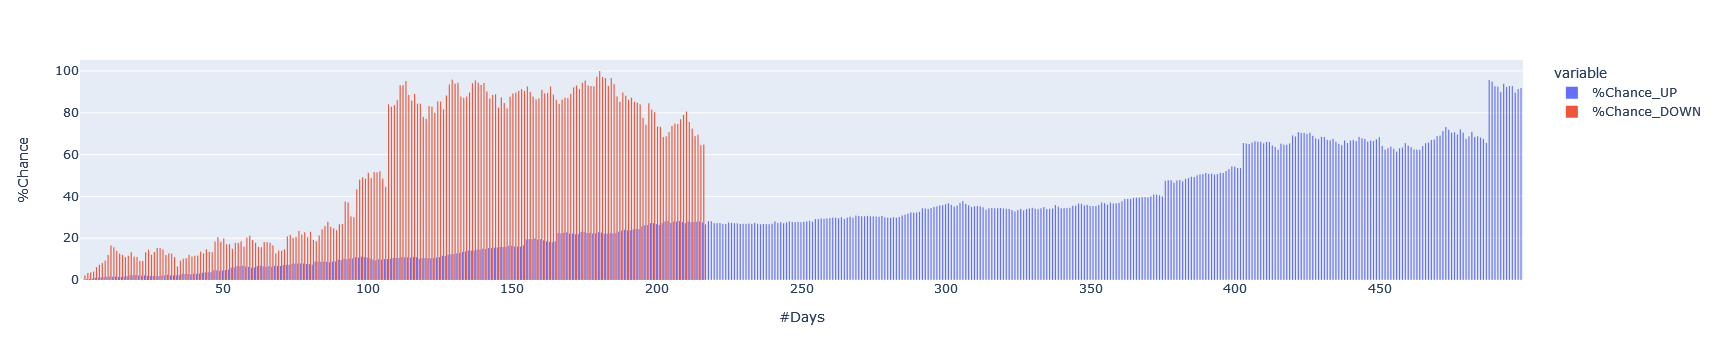

In [43]:

fig=px.bar(df3_tmp.loc[df3_tmp.index<500][['%Chance_UP','%Chance_DOWN']],barmode='group',labels={'value':'%Chance '})
fig.update_traces(dict(marker_line_width=0))
fig.show()

## ##################End of Stage 3###########################

# Stage -4 Backtest 

In [44]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2008-01-07   250.000000   252.199997   243.125000   243.899994   186.840515   
2008-01-08   245.000000   248.000000   242.324997   246.962494   189.186508   
2008-01-09   248.699997   251.500000   247.475006   249.074997   190.804764   
2008-01-10   249.500000   252.375000   240.500000   245.412506   187.999115   
2008-01-11   228.837494   251.000000   228.837494   247.437500   189.550415   
...                 ...          ...          ...          ...          ...   
2022-01-27  3731.000000  3733.399902  3625.100098  3649.250000  3649.250000   
2022-01-28  3646.000000  3729.800049  3646.000000  3690.050049  3690.050049   
2022-01-31  3749.000000  3758.000000  3721.399902  3736.250000  3736.250000   
2022-02-01  3770.000000  3808.000000  3736.399902  3800.649902  3800.649902   
2022-02-02  3827.899902  3864.000000  3800.649902  3856.199951  3856.199951   

             Volume  pct_change    RWEMA_252  RWEMA_252_movement  \
Date                                                               
2008-01-07  3647344   -2.944662   213.777026                -1.0   
2008-01-08  3207732    1.255613   213.556675                -2.0   
2008-01-09  2450128    0.855376   213.356548                -3.0   
2008-01-10  3342376   -1.470429   213.137899                -4.0   
2008-01-11  2149188    0.825163   212.938220                -5.0   
...             ...         ...          ...                 ...   
2022-01-27  5718297   -3.200348  3453.806471               398.0   
2022-01-28  3143862    1.118039  3455.782568               399.0   
2022-01-31  2739393    1.252014  3457.973897               400.0   
2022-02-01  2105169    1.723651  3460.587221               401.0   
2022-02-02  1983657    1.461593  3463.607396               402.0   

            RWEMA_252_price%movement  check  crossover  
Date                                                    
2008-01-07                  0.000000     -1          0  
2008-01-08                  1.255613     -1          0  
2008-01-09                  2.121729     -1          0  
2008-01-10                  0.620101     -1          0  
2008-01-11                  1.450381     -1          0  
...                              ...    ...        ...  
2022-01-27                 75.554045      1          0  
2022-01-28                 77.516809      1          0  
2022-01-31                 79.739344      1          0  
2022-02-01                 82.837423      1          0  
2022-02-02                 85.509763      1          0  

[3468 rows x 12 columns]

In [63]:
def backtest(start,end,init_df):    
    bt=pd.DataFrame({'StartDate':start,'EndDate':end})
    bt.replace(to_replace=np.nan,value=0,inplace=True)
    
    dataframes=[]
    pc_=[]
    
    # for index, row in bt.iterrows():
    #     init_df_tmp=init_df.iloc[np.where((init_df.index>=row['StartDate'])&(init_df.index<=row['EndDate']))]
    #     # init_df=init_df.reset_index()
    
    for index in bt.index:
        init_df_tmp=(init_df.loc[(init_df.index>=bt['StartDate'][index]) & (init_df.index<=bt['EndDate'][index])]).copy()
        # init_df=init_df.reset_index()
        
        pos=0
        num=0
        percentchange=[]
        day_count=0
        init_df_tmp['pos_days']=0
        init_df_tmp['s_daily_Return']=0.0
        s_st=[]
        #### price at time of start date of this stratgy
        u_st=init_df_tmp['Adj Close'][0]
        for i in init_df_tmp.index:
            CP=init_df_tmp['Adj Close'][i]
            init_df_tmp.at[i,'u_daily_Return']=((CP/u_st)-1)*100
            # print(f"current price {CP}")
            #############Long Position#####################
            ## Buy Condition
            if init_df_tmp['Adj Close'][i]> init_df_tmp['RWEMA_252'][i]:                
                if(pos==0):
                    print("Long Buy Triggred")
                    bp=CP
                    pos=1
                    print("Buying now at "+str(bp))
                    init_df_tmp.at[i,'pos_days']=day_count
                    if not s_st:
                        s_st.append(bp)
                    init_df_tmp.at[i,'s_daily_Return']=((CP/s_st[0])-1)*100
                else:
                    day_count+=1
                    init_df_tmp.at[i,'pos_days']=day_count
                    init_df_tmp.at[i,'s_daily_Return']=((CP/s_st[0])-1)*100
                    
            ## Sell Condition       
            elif init_df_tmp['Adj Close'][i]< init_df_tmp['RWEMA_252'][i]:                
                if(pos==1):
                    print("Short Buying Triggred")
                    day_count=0
                    pos=0
                    sp=CP
                    print("Existing now at "+str(sp))
                    pc=(sp/bp-1)*100
                    percentchange.append(pc)
                    init_df_tmp.at[i,'pos_days']=day_count
                
                if s_st: 
                    init_df_tmp.at[i,'s_daily_Return']=init_df_tmp['s_daily_Return'].shift(1)[i]
                else:
                    init_df_tmp.at[i,'s_daily_Return']=0
                   
            if(num==init_df_tmp["Adj Close"].count()-1 and pos==1):
                pos=0
                sp=CP
                day_count=0
                print("Existing now at "+str(sp))
                pc=(sp/bp-1)*100
                percentchange.append(pc)
                init_df_tmp.at[i,'pos_days']=day_count

            num+=1    
        pc_.append(percentchange)
        
        #################################for Performance Matrix############
        gains=0
        ng=0
        losses=0
        nl=0
        totalR=1

        for i in percentchange:
            if(i>0):
                gains+=i
                ng+=1
            else:
                losses+=i
                nl+=1
            totalR=totalR*((i/100)+1)

        totalR=round((totalR-1)*100,2)

        if(ng>0):
            avgGain=gains/ng
            maxR=max(percentchange)
        else:
            avgGain=0
            maxR=0

        if(nl>0):
            avgLoss=losses/nl
            maxL=min(percentchange)
            ratio=-avgGain/avgLoss
        else:
            avgLoss=0
            maxL=0
            ratio=999

        if(ng>0 or nl>0):
            battingAvg=(ng/(ng+nl))*100
        else:
            battingAvg=0

        # print()
        # print("Results for Sample size: "+str(ng+nl)+" trades")
        # # print("EMAs used: "+str(emasUsed))
        # print("Batting Avg: "+ str(battingAvg))
        # print("Gain/loss ratio: "+ ratio)
        # print("Average Gain: "+ str(avgGain))
        # print("Average Loss: "+ str(avgLoss))
        # print("Max Return: "+ maxR)
        # print("Max Loss: "+ maxL)
        # print("Total return over "+str(ng+nl)+ " trades: "+ str(totalR)+"%" )

        
        bt.at[index,'#Trades']=ng+nl
        bt.at[index,'Win avg']=round(battingAvg,2)
        bt.at[index,'#Wins']=ng
        bt.at[index,'#loss']=nl
        bt.at[index,'Gain/loss ratio']=round(ratio,2)
        bt.at[index,'Average Gain %']=round(avgGain,2)
        bt.at[index,'Average Loss %']=round(avgLoss,2)
        bt.at[index,'Max Return %']=round(maxR,2)
        bt.at[index,'Max Loss %']=round(maxL,2)
        bt.at[index,'Total return %']=round(totalR,2)
        
        dataframes.append(init_df_tmp)
        
        
        
            
   ### at this moment no matrix added into bt
    # print(f"stratgy start date{s_st}")
    # return pc_, init_df
    return bt, dataframes
    

In [64]:
# Yearly############
#start and end must be same length
start=['2008-01-07','2010-01-01','2011-01-01','2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01','2020-01-01','2021-02-01']
end=['2010-01-01','2011-02-01','2012-02-01','2013-02-01','2014-02-01','2015-02-01','2016-02-01','2017-02-01','2018-02-01','2019-02-01','2020-02-01','2021-02-01','2022-02-01']

# pc,init_df=backtest(start=start,end=end,init_df=df)
bt_y,init_df_matrix_y=backtest(start=start,end=end,init_df=df)

Long Buy Triggred
Buying now at 194.05062866210938
Short Buying Triggred
Existing now at 187.45709228515625
Long Buy Triggred
Buying now at 188.7449951171875
Short Buying Triggred
Existing now at 185.73658752441406
Long Buy Triggred
Buying now at 130.8379669189453
Short Buying Triggred
Existing now at 120.79534149169922
Long Buy Triggred
Buying now at 125.87062072753906
Short Buying Triggred
Existing now at 122.06172943115234
Long Buy Triggred
Buying now at 126.44979858398438
Existing now at 298.6651306152344
Long Buy Triggred
Buying now at 299.2224426269531
Existing now at 467.79388427734375
Long Buy Triggred
Buying now at 470.2144775390625
Short Buying Triggred
Existing now at 434.3686828613281
Long Buy Triggred
Buying now at 465.69580078125
Short Buying Triggred
Existing now at 424.35076904296875
Long Buy Triggred
Buying now at 452.3360900878906
Short Buying Triggred
Existing now at 447.3747863769531
Long Buy Triggred
Buying now at 459.2941589355469
Short Buying Triggred
Existing no

In [65]:
bt_y

StartDate     EndDate  #Trades  Win avg  #Wins  #loss  Gain/loss ratio  \
0   2008-01-07  2010-01-01      5.0    20.00    1.0    4.0            34.71   
1   2010-01-01  2011-02-01      1.0   100.00    1.0    0.0           999.00   
2   2011-01-01  2012-02-01      6.0    16.67    1.0    5.0             0.44   
3   2012-01-01  2013-02-01      7.0    42.86    3.0    4.0             1.09   
4   2013-01-01  2014-02-01      1.0   100.00    1.0    0.0           999.00   
5   2014-01-01  2015-02-01      2.0   100.00    2.0    0.0           999.00   
6   2015-01-01  2016-02-01     15.0     6.67    1.0   14.0             0.56   
7   2016-01-01  2017-02-01      5.0    20.00    1.0    4.0             0.10   
8   2017-01-01  2018-02-01      5.0    40.00    2.0    3.0            13.08   
9   2018-01-01  2019-02-01      2.0   100.00    2.0    0.0           999.00   
10  2019-01-01  2020-02-01      9.0    33.33    3.0    6.0             2.29   
11  2020-01-01  2021-02-01      5.0    40.00    2.0    3.0             6.10   
12  2021-02-01  2022-02-01      1.0   100.00    1.0    0.0           999.00   

    Average Gain %  Average Loss %  Max Return %  Max Loss %  Total return %  
0           136.19           -3.92        136.19       -7.68          101.02  
1            56.34            0.00         56.34        0.00           56.34  
2             1.80           -4.08          1.80       -8.88          -17.64  
3             4.63           -4.23          7.92       -7.56           -3.91  
4            80.35            0.00         80.35        0.00           80.35  
5             7.27            0.00         12.74        0.00           14.77  
6             0.71           -1.27          0.71       -3.75          -15.86  
7             0.15           -1.47          0.15       -3.28           -5.64  
8            15.03           -1.15         29.92       -1.69           25.66  
9            24.02            0.00         39.12        0.00           51.52  
10            4.45           -1.95         11.98       -4.71            0.84  
11           24.78           -4.06         49.41       -7.19           31.99  
12           22.37            0.00         22.37        0.00           22.37

In [70]:
init_df_matrix_y[-3]

Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-01-01  1896.000000  1910.000000  1885.000000  1902.800049  1785.039795   
2019-01-02  1905.000000  1934.449951  1900.000000  1923.300049  1804.270874   
2019-01-03  1919.000000  1944.949951  1893.099976  1899.949951  1782.365967   
2019-01-04  1900.000000  1901.199951  1841.000000  1876.849976  1760.695801   
2019-01-07  1891.800049  1908.800049  1881.000000  1897.900024  1780.442993   
...                 ...          ...          ...          ...          ...   
2020-01-27  2189.699951  2193.449951  2165.000000  2169.250000  2106.521484   
2020-01-28  2174.000000  2187.800049  2152.000000  2183.750000  2120.601807   
2020-01-29  2185.000000  2186.949951  2150.000000  2154.600098  2092.294678   
2020-01-30  2160.000000  2165.000000  2125.000000  2137.850098  2076.029053   
2020-01-31  2139.399902  2144.350098  2071.600098  2079.050049  2018.929443   

             Volume  pct_change    RWEMA_252  RWEMA_252_movement  \
Date                                                               
2019-01-01  1094883    0.515056  1711.068723               367.0   
2019-01-02  2100463    1.077347  1712.776141               368.0   
2019-01-03  2611668   -1.214059  1714.336558               369.0   
2019-01-04  4280862   -1.215809  1715.786342               370.0   
2019-01-07  1856423    1.121556  1717.346696               371.0   
...             ...         ...          ...                 ...   
2020-01-27  1549101   -0.648056  2032.767209                31.0   
2020-01-28  1743024    0.668416  2033.963873                32.0   
2020-01-29  2306761   -1.334863  2034.973214                33.0   
2020-01-30  2098567   -0.777406  2035.815632                34.0   
2020-01-31  3287223   -2.750424  2036.282924                -1.0   

            RWEMA_252_price%movement  check  crossover  pos_days  \
Date                                                               
2019-01-01                 59.496467      1          0         0   
2019-01-02                 61.214798      1          0         1   
2019-01-03                 59.257556      1          0         2   
2019-01-04                 57.321288      1          0         3   
2019-01-07                 59.085735      1          0         4   
...                              ...    ...        ...       ...   
2020-01-27                  4.969272      1          0        30   
2020-01-28                  5.670903      1          0        31   
2020-01-29                  4.260342      1          0        32   
2020-01-30                  3.449815      1          0        33   
2020-01-31                  0.000000     -1         -1         0   

            s_daily_Return  u_daily_Return  
Date                                        
2019-01-01        0.000000        0.000000  
2019-01-02        1.077347        1.077347  
2019-01-03       -0.149791       -0.149791  
2019-01-04       -1.363779       -1.363779  
2019-01-07       -0.257518       -0.257518  
...                    ...             ...  
2020-01-27       18.009777       18.009777  
2020-01-28       18.798573       18.798573  
2020-01-29       17.212775       17.212775  
2020-01-30       16.301556       16.301556  
2020-01-31       16.301556       13.102769  

[266 rows x 15 columns]

# 

In [56]:
###########Full
# start and end must be same length
start=['2008-01-07','2010-01-01','2011-01-01','2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01','2020-01-01']
end=['2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01','2022-02-01']

# pc,init_df=backtest(start=start,end=end,init_df=df)
result_matrix,init_df_matrix=backtest(start=start,end=end,init_df=df)


C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\anaconda\envs\market38\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Long Buy Triggred
Buying now at 194.05062866210938
Short Buying Triggred
Existing now at 187.45709228515625
Long Buy Triggred
Buying now at 188.7449951171875
Short Buying Triggred
Existing now at 185.73658752441406
Long Buy Triggred
Buying now at 130.8379669189453
Short Buying Triggred
Existing now at 120.79534149169922
Long Buy Triggred
Buying now at 125.87062072753906
Short Buying Triggred
Existing now at 122.06172943115234
Long Buy Triggred
Buying now at 126.44979858398438
Short Buying Triggred
Existing now at 434.3686828613281
Long Buy Triggred
Buying now at 465.69580078125
Short Buying Triggred
Existing now at 424.35076904296875
Long Buy Triggred
Buying now at 452.3360900878906
Short Buying Triggred
Existing now at 447.3747863769531
Long Buy Triggred
Buying now at 459.2941589355469
Short Buying Triggred
Existing now at 448.56878662109375
Long Buy Triggred
Buying now at 456.7619934082031
Short Buying Triggred
Existing now at 454.5180358886719
Long Buy Triggred
Buying now at 457.755

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\anaconda\envs\market38\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Short Buying Triggred
Existing now at 434.3686828613281
Long Buy Triggred
Buying now at 465.69580078125
Short Buying Triggred
Existing now at 424.35076904296875
Long Buy Triggred
Buying now at 452.3360900878906
Short Buying Triggred
Existing now at 447.3747863769531
Long Buy Triggred
Buying now at 459.2941589355469
Short Buying Triggred
Existing now at 448.56878662109375
Long Buy Triggred
Buying now at 456.7619934082031
Short Buying Triggred
Existing now at 454.5180358886719
Long Buy Triggred
Buying now at 457.7557678222656
Short Buying Triggred
Existing now at 463.2261657714844
Long Buy Triggred
Buying now at 468.53131103515625
Short Buying Triggred
Existing now at 441.0762634277344
Long Buy Triggred
Buying now at 493.03436279296875
Short Buying Triggred
Existing now at 516.52001953125
Long Buy Triggred
Buying now at 518.8995971679688
Short Buying Triggred
Existing now at 503.28546142578125
Long Buy Triggred
Buying now at 522.7196655273438
Short Buying Triggred
Existing now at 1029.26

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\anaconda\envs\market38\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Long Buy Triggred
Buying now at 522.7196655273438
Short Buying Triggred
Existing now at 1029.2626953125
Long Buy Triggred
Buying now at 1066.093017578125
Short Buying Triggred
Existing now at 1082.131103515625
Long Buy Triggred
Buying now at 1093.2154541015625
Short Buying Triggred
Existing now at 1090.9417724609375
Long Buy Triggred
Buying now at 1100.933349609375
Short Buying Triggred
Existing now at 1076.971923828125
Long Buy Triggred
Buying now at 1112.91357421875
Short Buying Triggred
Existing now at 1092.7999267578125
Long Buy Triggred
Buying now at 1098.003173828125
Short Buying Triggred
Existing now at 1105.849853515625
Long Buy Triggred
Buying now at 1116.5518798828125
Short Buying Triggred
Existing now at 1113.22021484375
Long Buy Triggred
Buying now at 1123.480224609375
Short Buying Triggred
Existing now at 1118.067138671875
Long Buy Triggred
Buying now at 1126.5145263671875
Short Buying Triggred
Existing now at 1122.2022705078125
Long Buy Triggred
Buying now at 1146.2618408

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\anaconda\envs\market38\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Long Buy Triggred
Buying now at 485.2530822753906
Short Buying Triggred
Existing now at 448.56878662109375
Long Buy Triggred
Buying now at 456.7619934082031
Short Buying Triggred
Existing now at 454.5180358886719
Long Buy Triggred
Buying now at 457.7557678222656
Short Buying Triggred
Existing now at 463.2261657714844
Long Buy Triggred
Buying now at 468.53131103515625
Short Buying Triggred
Existing now at 441.0762634277344
Long Buy Triggred
Buying now at 493.03436279296875
Short Buying Triggred
Existing now at 516.52001953125
Long Buy Triggred
Buying now at 518.8995971679688
Short Buying Triggred
Existing now at 503.28546142578125
Long Buy Triggred
Buying now at 522.7196655273438
Short Buying Triggred
Existing now at 1029.2626953125
Long Buy Triggred
Buying now at 1066.093017578125
Short Buying Triggred
Existing now at 1082.131103515625
Long Buy Triggred
Buying now at 1093.2154541015625
Short Buying Triggred
Existing now at 1090.9417724609375
Long Buy Triggred
Buying now at 1100.9333496

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\anaconda\envs\market38\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Short Buying Triggred
Existing now at 1092.7999267578125
Long Buy Triggred
Buying now at 1098.003173828125
Short Buying Triggred
Existing now at 1105.849853515625
Long Buy Triggred
Buying now at 1116.5518798828125
Short Buying Triggred
Existing now at 1113.22021484375
Long Buy Triggred
Buying now at 1123.480224609375
Short Buying Triggred
Existing now at 1118.067138671875
Long Buy Triggred
Buying now at 1126.5145263671875
Short Buying Triggred
Existing now at 1122.2022705078125
Long Buy Triggred
Buying now at 1146.2618408203125
Short Buying Triggred
Existing now at 1126.64697265625
Long Buy Triggred
Buying now at 1127.664306640625
Short Buying Triggred
Existing now at 1125.7403564453125
Long Buy Triggred
Buying now at 1128.659423828125
Short Buying Triggred
Existing now at 1122.1361083984375
Long Buy Triggred
Buying now at 1127.9296875
Short Buying Triggred
Existing now at 1117.5145263671875
Long Buy Triggred
Buying now at 1141.219482421875
Short Buying Triggred
Existing now at 1098.45

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\anaconda\envs\market38\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Long Buy Triggred
Buying now at 912.9586791992188
Short Buying Triggred
Existing now at 1029.2626953125
Long Buy Triggred
Buying now at 1066.093017578125
Short Buying Triggred
Existing now at 1082.131103515625
Long Buy Triggred
Buying now at 1093.2154541015625
Short Buying Triggred
Existing now at 1090.9417724609375
Long Buy Triggred
Buying now at 1100.933349609375
Short Buying Triggred
Existing now at 1076.971923828125
Long Buy Triggred
Buying now at 1112.91357421875
Short Buying Triggred
Existing now at 1092.7999267578125
Long Buy Triggred
Buying now at 1098.003173828125
Short Buying Triggred
Existing now at 1105.849853515625
Long Buy Triggred
Buying now at 1116.5518798828125
Short Buying Triggred
Existing now at 1113.22021484375
Long Buy Triggred
Buying now at 1123.480224609375
Short Buying Triggred
Existing now at 1118.067138671875
Long Buy Triggred
Buying now at 1126.5145263671875
Short Buying Triggred
Existing now at 1122.2022705078125
Long Buy Triggred
Buying now at 1146.2618408

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\anaconda\envs\market38\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Short Buying Triggred
Existing now at 1095.529052734375
Long Buy Triggred
Buying now at 1111.0164794921875
Short Buying Triggred
Existing now at 1097.1746826171875
Long Buy Triggred
Buying now at 1111.9407958984375
Short Buying Triggred
Existing now at 1103.22705078125
Long Buy Triggred
Buying now at 1089.9793701171875
Short Buying Triggred
Existing now at 1091.4793701171875
Long Buy Triggred
Buying now at 1104.1158447265625
Short Buying Triggred
Existing now at 1087.8428955078125
Long Buy Triggred
Buying now at 1104.161376953125
Short Buying Triggred
Existing now at 1085.5037841796875
Long Buy Triggred
Buying now at 1090.9737548828125
Short Buying Triggred
Existing now at 1087.87109375
Long Buy Triggred
Buying now at 1119.1719970703125
Short Buying Triggred
Existing now at 1701.03173828125
Long Buy Triggred
Buying now at 1752.205810546875
Short Buying Triggred
Existing now at 1962.0626220703125
Long Buy Triggred
Buying now at 1983.9112548828125
Short Buying Triggred
Existing now at 19

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\anaconda\envs\market38\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Long Buy Triggred
Buying now at 1090.9737548828125
Short Buying Triggred
Existing now at 1087.87109375
Long Buy Triggred
Buying now at 1119.1719970703125
Short Buying Triggred
Existing now at 1701.03173828125
Long Buy Triggred
Buying now at 1752.205810546875
Short Buying Triggred
Existing now at 1962.0626220703125
Long Buy Triggred
Buying now at 1983.9112548828125
Short Buying Triggred
Existing now at 1953.228271484375
Long Buy Triggred
Buying now at 1994.2183837890625
Short Buying Triggred
Existing now at 1956.8380126953125
Long Buy Triggred
Buying now at 1975.26708984375
Short Buying Triggred
Existing now at 1945.2010498046875
Long Buy Triggred
Buying now at 1967.751953125
Short Buying Triggred
Existing now at 1982.9637451171875
Long Buy Triggred
Buying now at 2012.70849609375
Short Buying Triggred
Existing now at 1989.3583984375
Long Buy Triggred
Buying now at 2013.8223876953125
Short Buying Triggred
Existing now at 1996.334228515625
Long Buy Triggred
Buying now at 2006.798217773437

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\anaconda\envs\market38\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Long Buy Triggred
Buying now at 1089.9793701171875
Short Buying Triggred
Existing now at 1091.4793701171875
Long Buy Triggred
Buying now at 1104.1158447265625
Short Buying Triggred
Existing now at 1087.8428955078125
Long Buy Triggred
Buying now at 1104.161376953125
Short Buying Triggred
Existing now at 1085.5037841796875
Long Buy Triggred
Buying now at 1090.9737548828125
Short Buying Triggred
Existing now at 1087.87109375
Long Buy Triggred
Buying now at 1119.1719970703125
Short Buying Triggred
Existing now at 1701.03173828125
Long Buy Triggred
Buying now at 1752.205810546875
Short Buying Triggred
Existing now at 1962.0626220703125
Long Buy Triggred
Buying now at 1983.9112548828125
Short Buying Triggred
Existing now at 1953.228271484375
Long Buy Triggred
Buying now at 1994.2183837890625
Short Buying Triggred
Existing now at 1956.8380126953125
Long Buy Triggred
Buying now at 1975.26708984375
Short Buying Triggred
Existing now at 1945.2010498046875
Long Buy Triggred
Buying now at 1967.751

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\anaconda\envs\market38\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Long Buy Triggred
Buying now at 1222.7386474609375
Short Buying Triggred
Existing now at 1701.03173828125
Long Buy Triggred
Buying now at 1752.205810546875
Short Buying Triggred
Existing now at 1962.0626220703125
Long Buy Triggred
Buying now at 1983.9112548828125
Short Buying Triggred
Existing now at 1953.228271484375
Long Buy Triggred
Buying now at 1994.2183837890625
Short Buying Triggred
Existing now at 1956.8380126953125
Long Buy Triggred
Buying now at 1975.26708984375
Short Buying Triggred
Existing now at 1945.2010498046875
Long Buy Triggred
Buying now at 1967.751953125
Short Buying Triggred
Existing now at 1982.9637451171875
Long Buy Triggred
Buying now at 2012.70849609375
Short Buying Triggred
Existing now at 1989.3583984375
Long Buy Triggred
Buying now at 2013.8223876953125
Short Buying Triggred
Existing now at 1996.334228515625
Long Buy Triggred
Buying now at 2006.7982177734375
Short Buying Triggred
Existing now at 2018.929443359375
Long Buy Triggred
Buying now at 2041.70166015

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\anaconda\envs\market38\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Long Buy Triggred
Buying now at 1983.9112548828125
Short Buying Triggred
Existing now at 1953.228271484375
Long Buy Triggred
Buying now at 1994.2183837890625
Short Buying Triggred
Existing now at 1956.8380126953125
Long Buy Triggred
Buying now at 1975.26708984375
Short Buying Triggred
Existing now at 1945.2010498046875
Long Buy Triggred
Buying now at 1967.751953125
Short Buying Triggred
Existing now at 1982.9637451171875
Long Buy Triggred
Buying now at 2012.70849609375
Short Buying Triggred
Existing now at 1989.3583984375
Long Buy Triggred
Buying now at 2013.8223876953125
Short Buying Triggred
Existing now at 1996.334228515625
Long Buy Triggred
Buying now at 2006.7982177734375
Short Buying Triggred
Existing now at 2018.929443359375
Long Buy Triggred
Buying now at 2041.70166015625
Short Buying Triggred
Existing now at 2044.61474609375
Long Buy Triggred
Buying now at 2063.599853515625
Short Buying Triggred
Existing now at 1915.3150634765625
Long Buy Triggred
Buying now at 2000.6182861328

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\admin\AppData\Local\Temp/ipykernel_25216/2313617412.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\anaconda\envs\market38\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [57]:
result_matrix

StartDate     EndDate  #Trades  Win avg  #Wins  #loss  Gain/loss ratio  \
0   2008-01-07  2022-02-01     51.0    27.45   14.0   37.0            17.02   
1   2010-01-01  2022-02-01     47.0    29.79   14.0   33.0            11.46   
2   2011-01-01  2022-02-01     47.0    27.66   13.0   34.0             9.60   
3   2012-01-01  2022-02-01     44.0    29.55   13.0   31.0            10.66   
4   2013-01-01  2022-02-01     38.0    28.95   11.0   27.0            15.15   
5   2014-01-01  2022-02-01     38.0    28.95   11.0   27.0            10.08   
6   2015-01-01  2022-02-01     37.0    24.32    9.0   28.0            10.96   
7   2016-01-01  2022-02-01     22.0    36.36    8.0   14.0            10.56   
8   2017-01-01  2022-02-01     17.0    41.18    7.0   10.0            11.32   
9   2018-01-01  2022-02-01     13.0    46.15    6.0    7.0            10.33   
10  2019-01-01  2022-02-01     13.0    38.46    5.0    8.0             7.71   
11  2020-01-01  2022-02-01      5.0    40.00    2.0    3.0            10.21   

    Average Gain %  Average Loss %  Max Return %  Max Loss %  Total return %  
0            35.51           -2.09        243.51       -8.88          955.35  
1            21.35           -1.86         96.91       -8.88          424.01  
2            19.52           -2.03         96.91       -8.88          233.46  
3            19.52           -1.83         96.91       -7.56          279.11  
4            22.35           -1.48         95.02       -7.19          321.69  
5            14.87           -1.48         82.84       -7.19          143.77  
6            16.59           -1.51         82.84       -7.19          107.52  
7            18.58           -1.76         82.84       -7.19          146.63  
8            21.21           -1.87         82.84       -7.19          161.37  
9            22.58           -2.18         82.84       -7.19          147.35  
10           19.27           -2.50         82.84       -7.19           69.43  
11           41.49           -4.06         82.84       -7.19           61.51

In [58]:
init_df_matrix

[                   Open         High          Low        Close    Adj Close  \
 Date                                                                          
 2008-01-07   250.000000   252.199997   243.125000   243.899994   186.840515   
 2008-01-08   245.000000   248.000000   242.324997   246.962494   189.186508   
 2008-01-09   248.699997   251.500000   247.475006   249.074997   190.804764   
 2008-01-10   249.500000   252.375000   240.500000   245.412506   187.999115   
 2008-01-11   228.837494   251.000000   228.837494   247.437500   189.550415   
 ...                 ...          ...          ...          ...          ...   
 2022-01-25  3769.500000  3809.399902  3722.199951  3769.899902  3769.899902   
 2022-01-27  3731.000000  3733.399902  3625.100098  3649.250000  3649.250000   
 2022-01-28  3646.000000  3729.800049  3646.000000  3690.050049  3690.050049   
 2022-01-31  3749.000000  3758.000000  3721.399902  3736.250000  3736.250000   
 2022-02-01  3770.000000  3808.000000  3

In [ ]:
fig=px.line(init_df[['s_daily_Return','u_daily_Return']],)
fig.show()

# How to Change value of a Element in Data frame 

"You can use following commands to get the value of element for specfic row and column /n "

df['col']['row']
or
df.at['row','col']

when running for loop like (for i in df.index), i will itrate over each row (or in other words each index of dataframe).

To find previous element of current index 
Tdf['x'].shift(1)['C']

ex: 
"for i in df.index:
    current_value_of_x=df['x'][i]
    previous-value_of_x=df['x'].shift(1)[i]"

In [ ]:
Tdf = pd.DataFrame(index=['A','B','C'], columns=['x','y'])

In [ ]:
Tdf['x']['B'], Tdf.at['B','x']

In [ ]:
for i in Tdf.index:
    # print(Tdf['x'][i])
    if Tdf['x'][i]==0:
        Tdf.at[i,'x']=5


In [ ]:
Tdf.at['B','z']=0

In [ ]:
Tdf

## Example Ends

In [ ]:
for index, row in Tdf.iterrows():
    Tdf.at[index,'y']=0

In [ ]:
Tdf

In [ ]:
d=df.copy()
d.reset_index(inplace=True)
for i in d.index:
    last=df.iloc[i-1]['Close']
last

In [ ]:
df

In [ ]:
# This is how to get element position .
np.where(df.check==-1),np.where(df.check==1)

In [ ]:
df.iloc[96]

In [ ]:
#####Calcuate % Day reach 
tmp['%dayreach']=np.where(tmp.Close>0,(tmp.Close/tmp.loc[tmp.index>0].max()[0])*100,
                         (tmp.Close/tmp.loc[tmp.index<0].max()[0])*100)
tmp.reset_index(inplace=True)
tmp.rename(columns={'RWEMA_252_movement':'#Days','Close':'#Reversal_count','%dayreach':'%Sucess'},inplace=True)
tmp.set_index('#Days',inplace=True)

In [ ]:
tmp

In [ ]:
# (data/data.max()*100).sort_values(ascending = False)[-1:10]

In [ ]:
fig=px.scatter(x=tmp.index,y=tmp['%Sucess'],size=tmp['#Reversal_count'],hover_name=tmp['%Sucess'])
fig.show()

In [ ]:
fig=px.scatter(x=tmp.index,y=tmp['%Reversal'])
fig.show()

In [ ]:
check=tmp.loc[tmp.index>0]

In [ ]:
check['#Passed']=check['#Reversal_count'].shift(-1)
check.replace(to_replace=np.nan,value=0,inplace=True)
check['#failed']=check['#Reversal_count']-check['#Passed']
check.replace(to_replace=np.nan,value=0,inplace=True)

In [ ]:
check['cumfailed']=check['#failed'].cumsum()

In [ ]:
check[:11]

In [ ]:
check['%cumfailed']=(check['cumfailed']/check['cumfailed'].max())*100

In [ ]:
fig=px.scatter(check['cumfailed'])
fig.show()

In [ ]:
fig=px.scatter(check['%cumfailed'])
fig.show()

In [ ]:
check['%Passed']=(check['#Passed']/check['#Reversal_count'].max())*100

In [ ]:
check

In [ ]:
fig=px.scatter(x=check.index,y=check['%Passed'],size=check['#Passed'])
fig.show()

In [ ]:
# df['RWEMA_252_movement'].mask(df['check']>1,(df['check'].cumsum()))

In [ ]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,)
trace0 = go.Scatter(x=df.index,y=df['Close'],mode='lines',name='Close')
trace2 = go.Scatter(x=df.index,y=df['RWEMA_252'],mode='lines',name='RWEMA_252')
trace1 = go.Bar(x=df.index,y=df['RWEMA_252_movement'],name='# consicutive times trading above or below 252')

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace1, 2, 1)

fig.update_traces(dict(marker_line_width=0))
# fig = px.line(df[['Close','RWEMA_252','RWEMA_252_movement']],title="")
                
# fig.update_traces(marker_color='green')
fig.update_layout(autosize=False,width=1600,height=800,paper_bgcolor="white",)
fig.show()

In [ ]:
for index, row in df.iterrows():
    print(f"Index Value is {index}")
    print(f"row Value is {row}")
    print (row['Close'])
    